<a href="https://colab.research.google.com/github/amanichivilkar/Landmarks_Detection/blob/main/Landmarks_Detection_On_The_Body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Computer Vision Task** 

  *TASK 1* : The task  is to get all the landmarks on the body from the image and save the image as result [image format].

  *TASK 2* : For this task, the input is live feed from a webcam.In this section, you should get only  the specified landmarks on the body.
Geting only  the specified landmarks on the body that are:
* Nose
* Left shoulder 
* Right shoulder
* Right elbow
* Left elbow
* Right knee
* Left knee 
* Right ankle
* Left ankle

Result to be submitted in this section using Google colab Notebook.

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import base64
from PIL import Image

### Getting Webcam frame on colab using java script




In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }

    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_live_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    return np.asarray(image_PIL)

def image_to_bytes(image_openpose):
    image = Image.fromarray(image_openpose, 'RGB')
    iobuf = io.BytesIO()
    image.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

### **TensorFlow 2 OpenPose Install and import libraries**

In [ ]:
!pip install tf_pose

In [ ]:
import tf_pose

from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

#Parameters
model='mobilenet_thin'
resize='432x368'
w, h = model_wh(resize)

#Create estimator
if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

### **Landmarks On The Body From The Image using TensorFlow 2 OpenPose**

*  OpenCV is used to read images. The images are stored as RGB, but internally, OpenCV works with BGR. Using OpenCV we can converted from BGR to RGB before using image

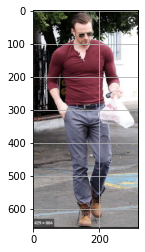

In [ ]:
image_path = "/content/drive/MyDrive/Colab Notebooks/image3.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
plt.imshow(image)
plt.grid();

*  Spite that the image can be read using OpenCV; we will use the function read_imgfile(image_path) from the library tf_pose.common to prevent any trouble with color channels.

In [ ]:
image = common.read_imgfile(image_path, None, None)

*  Once we have the image as an array, we can apply the method inference to the estimator (e), having the image array as input (the image will be resized using the parameters w and h defined at principle)

In [ ]:
humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

* Draw the skeleton using method draw_human

In [ ]:
image_openpose = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

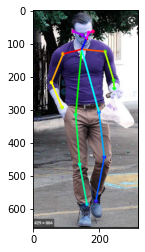

In [ ]:
plt.imshow(image_openpose)

### **Pose Estimation on webcam using TensorFlow 2 OpenPose**

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''

while True:
    js_reply = take_live_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)

    humans = e.inference(image,
                         resize_to_default=(w > 0 and h > 0),
                         upsample_size=4.0)
    image_openpose = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

    drawing_bytes = image_to_bytes(image_openpose)
    img_data = drawing_bytes

<IPython.core.display.Javascript object>

### **Mediapipe Install and import libraries**

In [ ]:
!pip install mediapipe opencv-python

     |████████████████████████████████| 32.8 MB 280 kB/s 


In [ ]:
import mediapipe as mp
import cv2
from google.colab.patches import cv2_imshow

### **Full Body Estimation on webcam using Media Pipe Holistic**

In [ ]:
mp_drawing = mp.solutions.drawing_utils # to draw the landmark
mp_holistic = mp.solutions.holistic

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''

while True:
    js_reply = take_live_photo(label_html, img_data)
    if not js_reply:
        break

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
          
          # convert JS response to OpenCV Image
          image = js_reply_to_image(js_reply)

          # Recolor Feed
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

          # Make Detections
          results = holistic.process(image)
          
          # print(results.face_landmarks) # this gives array of all possition of the land mark

          # Recolor image back to BGR for rendering
          image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
          
          # Draw face landmarks
          # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.HAND_CONNECTIONS)

          # Right hand
          # mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

          # Left Hand
          mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(250,0,0), thickness=5, circle_radius=5),
                                 mp_drawing.DrawingSpec(color=(0,0,0), thickness=0, circle_radius=0)
                                 )

          # Pose Detections
          mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)

          drawing_bytes = image_to_bytes(image)
          img_data = drawing_bytes

<IPython.core.display.Javascript object>

### **Full Body Estimation on on image using Media Pipe Holistic**

In [ ]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

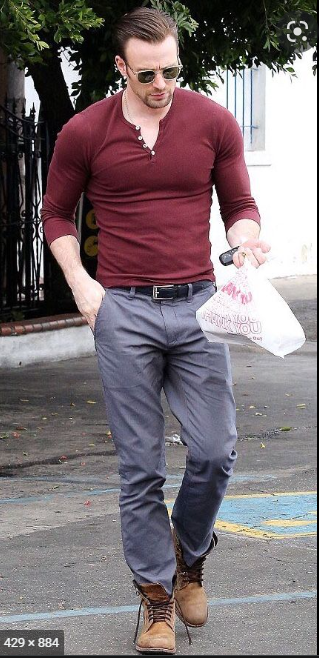

In [ ]:
image_path = "/content/drive/MyDrive/Colab Notebooks/image3.png"
image = cv2.imread(image_path)
cv2_imshow(image)

In [ ]:
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)

In [ ]:
# Perform pose detection with MediaPipe Pose after Convert the BGR image to RGB .
results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
# landmark lists
results.pose_landmarks

In [ ]:
# Co-ordinates of specific land marks
land_mark_index=2
results.pose_landmarks.landmark[mp_pose.PoseLandmark(land_mark_index)]

x: 0.5342714190483093
y: 0.10920732468366623
z: -0.406023234128952
visibility: 0.9995712637901306

In [ ]:
# Specifiv land mark name 
mp_pose.PoseLandmark(land_mark_index).name # its left eye

'LEFT_EYE'

In [ ]:
# Normalized Landmark List
# Check if landmarks are found
if  results.pose_landmarks:
   
   # Itrate over two item as we want only two landmarks
   for i in [0,1]:
       print(f"{mp_pose.PoseLandmark(i).name} \n {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i)]}")

NOSE 
 x: 0.5094309449195862
y: 0.13393467664718628
z: -0.43039408326148987
visibility: 0.9997814297676086

LEFT_EYE_INNER 
 x: 0.5194908976554871
y: 0.11188975721597672
z: -0.4050501585006714
visibility: 0.9995137453079224



In [ ]:
# Actual Landmark List co-ordinate
image_hight, image_width, _ = image.shape
if  results.pose_landmarks:
  for i in [1,2]:

    print( f"{mp_pose.PoseLandmark(i).name}")
    print( f'x : {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].x * image_width}')
    print( f'y : {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].y * image_hight}')
    print( f'z : {results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value].z * image_width}')

LEFT_EYE_INNER
x : 165.71759635210037
y : 73.62346024811268
z : -129.21100056171417
LEFT_EYE
x : 170.43258267641068
y : 71.85841964185238
z : -129.5214116871357


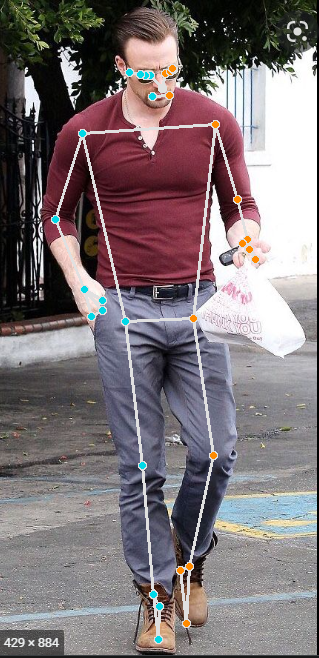

In [ ]:
# create a copy of the image to draw the landmark
image_copy = image.copy()

if  results.pose_landmarks:

      # To draw landmark
      mp_drawing.draw_landmarks(image_copy , 
                                results.pose_landmarks , 
                                mp_pose.POSE_CONNECTIONS,
                               landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
      
      cv2_imshow(image_copy)

### **Human Pose Estimation using Tensorflow frozen modle**

**Clone the Tensorflow frozen modle  and Import dependencies**

In [ ]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
!git clone https://github.com/misbah4064/human-pose-estimation-opencv.git
%cd human-pose-estimation-opencv/

Cloning into 'human-pose-estimation-opencv'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 5), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (20/20), done.
/content/human-pose-estimation-opencv


In [ ]:
BODY_PARTS = { "Nose": 0, "RShoulder": 2, "RElbow": 3,
               "LShoulder": 5, "LElbow": 6, "RKnee": 9,
               "RAnkle": 10, "LKnee": 12, "LAnkle": 13, "Background": 18 }

# POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
#                ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
#                ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
#                ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
#                ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

width = 368
height = 368
inWidth = width
inHeight = height

net = cv.dnn.readNetFromTensorflow("graph_opt.pb") ## pretained weights
thr = 0.5

### **Applying Tensorflow frozen modle on live feed from a webcam (TASK 2.)**
### **For this task, the input is live feed from a webcam. In this section, you should get only  the specified landmarks on the body**

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''

while True:
    js_reply = take_live_photo(label_html, img_data)
    if not js_reply:
        break   
          
    # convert JS response to OpenCV Image
    frame = js_reply_to_image(js_reply)

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements


    points = []
    for i in range(19):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for parts in BODY_PARTS.keys():
      
        assert(parts in BODY_PARTS)
        
        idFrom = BODY_PARTS[parts]

        if points[idFrom]:
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()


    drawing_bytes = image_to_bytes(frame)
    img_data = drawing_bytes

<IPython.core.display.Javascript object>

 **Click on the video link below to see the result of the task 2.**


Since, only the upper body was captured by the webcam, the modle detected half of the landmarks (like Nose, Left shoulder, Right shoulder, Right elbow and Left elbow) . The whole body could not be captured in a single frame as the room is small. But it works well, as you can see the same code applied on the image shown below .



### **Applying Tensorflow frozen modle on Image**

In [ ]:
def poseDetector(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements


    points = []
    for i in range(19):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for parts in BODY_PARTS.keys():
      
        assert(parts in BODY_PARTS)
        
        idFrom = BODY_PARTS[parts]

        if points[idFrom]:
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()

    return frame

Geting only  the specified landmarks on the body that are:
* Nose
* Left shoulder 
* Right shoulder
* Right elbow
* Left elbow
* Right knee
* Left knee 
* Right ankle
* Left ankle


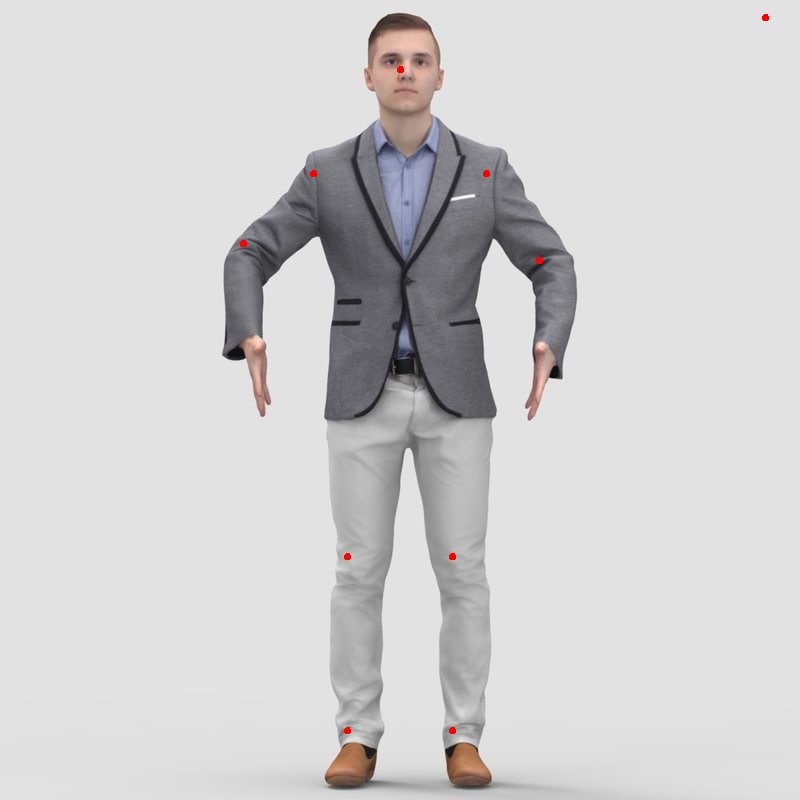

In [ ]:
input = cv.imread("image.jpg")
output = poseDetector(input)
cv2_imshow(output)